**FORECASTING EXCHANGE USING TIME SERIES ANALYSIS**

1. Data Preparation and Exploration

In [6]:
import pandas as pd

# Load the dataset
df = pd.read_csv('exchange_rate.csv', parse_dates=['date'])
df.set_index('date', inplace=True)
print(df.head())

                  Ex_rate
date                     
01-01-1990 00:00   0.7855
02-01-1990 00:00   0.7818
03-01-1990 00:00   0.7867
04-01-1990 00:00   0.7860
05-01-1990 00:00   0.7849


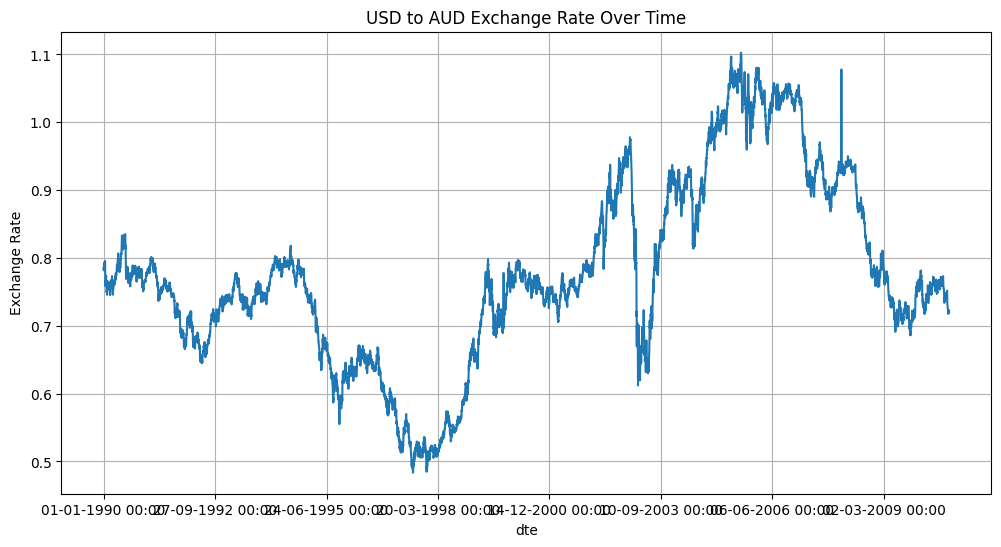

In [10]:
import matplotlib.pyplot as plt

df['Ex_rate'].plot(title='USD to AUD Exchange Rate Over Time', figsize=(12, 6))
plt.ylabel('Exchange Rate')
plt.xlabel('dte')
plt.grid(True)
plt.show()

In [13]:
print(df.isnull().sum())
df.fillna(method='ffill', inplace=True)
import numpy as np
rolling_mean = df['Ex_rate'].rolling(window=12).mean()
rolling_std = df['Ex_rate'].rolling(window=12).std()
z_scores = (df['Ex_rate'] - rolling_mean) / rolling_std
df['Ex_rate'] = np.where(np.abs(z_scores) > 3, rolling_mean, df['Ex_rate'])

Ex_rate    0
dtype: int64


<ipython-input-13-7353629f2ef3>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


2. ARIMA Modeling

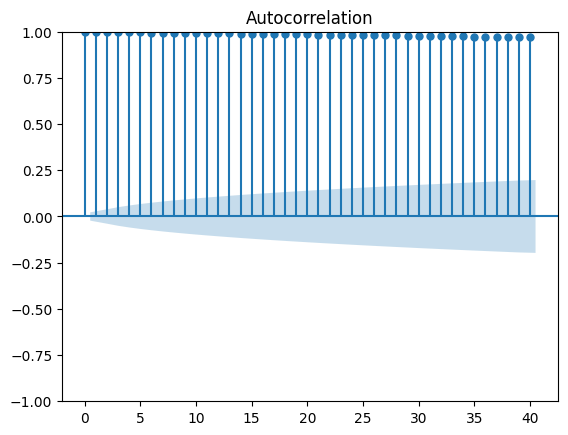

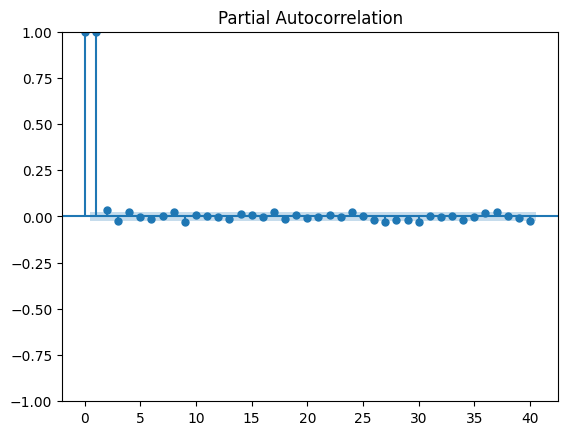

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Ex_rate'].dropna(), lags=40)
plt.show()

plot_pacf(df['Ex_rate'].dropna(), lags=40)
plt.show()

In [20]:
from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(df['Ex_rate'], order=(1, 1, 1))
results_arima = model_arima.fit()

print(results_arima.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28863.741
Date:                Mon, 09 Jun 2025   AIC                         -57721.482
Time:                        17:11:24   BIC                         -57700.679
Sample:                             0   HQIC                        -57714.342
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8688      0.024    -35.583      0.000      -0.917      -0.821
ma.L1          0.8358      0.027     31.047      0.000       0.783       0.889
sigma2      2.904e-05   1.92e-07    151.616      0.0

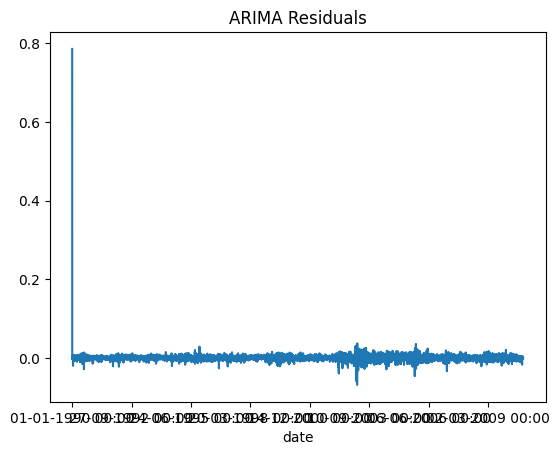

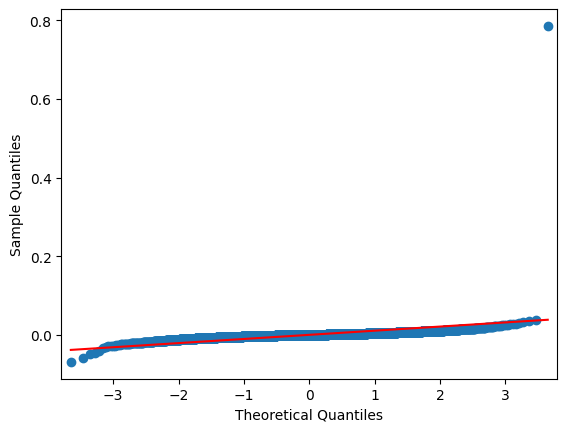

In [19]:
residuals = results_arima.resid
residuals.plot(title='ARIMA Residuals')
plt.show()

# Q-Q plot
import statsmodels.api as sm
sm.qqplot(residuals, line='s')
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


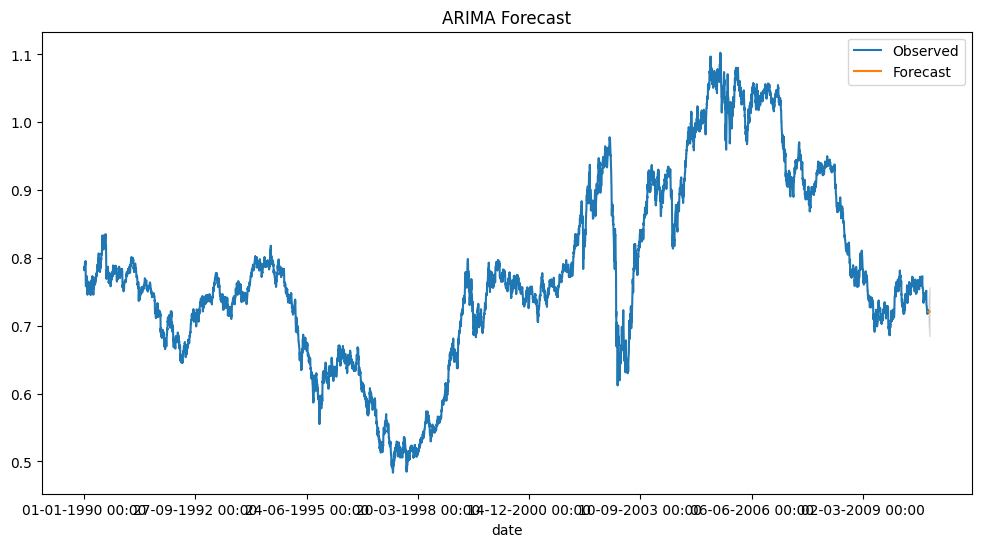

In [22]:
forecast = results_arima.get_forecast(steps=12)
forecast_df = forecast.summary_frame()

# Plot
df['Ex_rate'].plot(label='Observed', figsize=(12, 6))
forecast_df['mean'].plot(label='Forecast')
plt.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], color='k', alpha=0.1)
plt.legend()
plt.title('ARIMA Forecast')
plt.show()

3. Exponential Smoothing

In [24]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_hw = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None)
fit_hw = model_hw.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


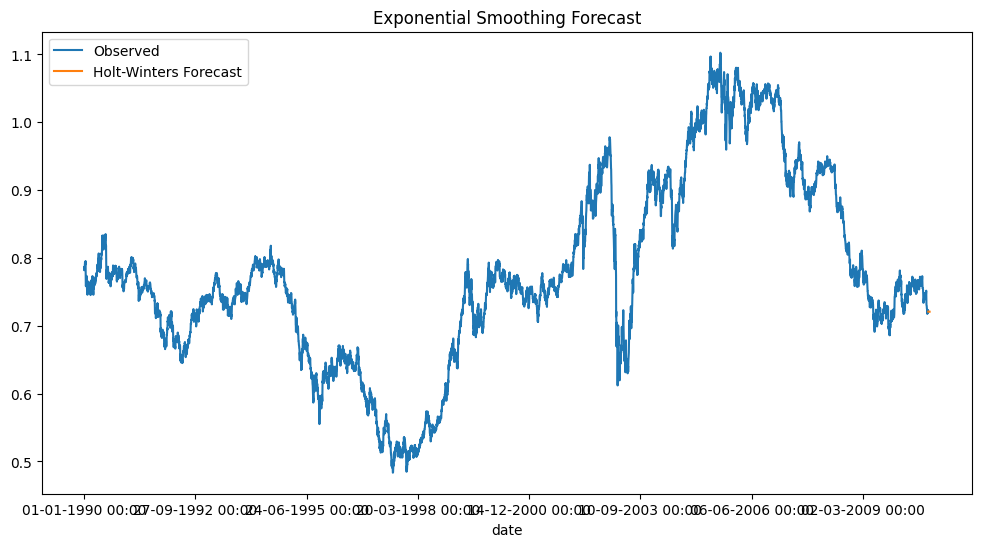

In [25]:
forecast_hw = fit_hw.forecast(steps=12)

# Plot
df['Ex_rate'].plot(label='Observed', figsize=(12, 6))
forecast_hw.plot(label='Holt-Winters Forecast')
plt.title('Exponential Smoothing Forecast')
plt.legend()
plt.show()


4. Evaluation and Comparison

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np # Make sure numpy is imported for np.sqrt

# For ARIMA
arima_pred = forecast_df['mean']
true_values = df['Ex_rate'][-12:]  # Adjust if using train/test split

mae_arima = mean_absolute_error(true_values, arima_pred)
# Removed squared=False and take the square root of the result for RMSE
mse_arima = mean_squared_error(true_values, arima_pred)
rmse_arima = np.sqrt(mse_arima)
mape_arima = np.mean(np.abs((true_values - arima_pred) / true_values)) * 100

# For Exponential Smoothing
hw_pred = forecast_hw
mae_hw = mean_absolute_error(true_values, hw_pred)
# Removed squared=False and take the square root of the result for RMSE
mse_hw = mean_squared_error(true_values, hw_pred)
rmse_hw = np.sqrt(mse_hw)
mape_hw = np.mean(np.abs((true_values - hw_pred) / true_values)) * 100

print(f"ARIMA MAE: {mae_arima:.4f}, RMSE: {rmse_arima:.4f}, MAPE: {mape_arima:.2f}%")
print(f"HW MAE: {mae_hw:.4f}, RMSE: {rmse_hw:.4f}, MAPE: {mape_hw:.2f}%")

ARIMA MAE: 0.0017, RMSE: 0.0020, MAPE: nan%
HW MAE: 0.0017, RMSE: 0.0020, MAPE: nan%
